# A Model for Genre Classification 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import re
import scipy as sp
import warnings
#%matplotlib inline
import os
import sys

Loading raw data 

In [2]:
tracks = "tracks.csv"
sessions = "sessions.csv"
tracks_to_complete = "tracks_to_complete.csv"

df_tracks = pd.read_csv(tracks)
df_sessions = pd.read_csv(sessions)
df_tracks_to_complete = pd.read_csv(tracks_to_complete)

Before dealing with any model it is worth exploring the dataframes in order to understand the statistics and to perform some data quality checks.

#### Lyrics data exploration 

Let's check some properties of the genre distribution

In [3]:
print df_tracks.shape
df_tracks = df_tracks.drop_duplicates(keep="first")
df_tracks.head(5)

(4985, 3)


,song_id,duration,genre
0,13460427505664,142.0,rock
1,4707284156416,259.0,reggae
2,2525440770048,36.0,rock
3,16973710753795,216.0,blues
4,3642132267010,19.0,rock


In [4]:
df_tracks['duration'].describe(include='all')
genres = df_tracks["genre"].unique()

In [5]:
describeTracks = df_tracks[["genre","duration"]].groupby("genre").describe()
describeTracks 

duration                                                        
           count        mean        std  min    25%   50%     75%    max
genre                                                                   
blues      769.0   91.093628  70.877032  0.0  36.00  74.0  129.00  364.0
electro    376.0  100.917553  75.351133  0.0  35.75  89.0  155.25  368.0
rap        567.0   96.303351  73.878085  0.0  37.00  80.0  141.00  489.0
reggae     757.0   93.976222  67.101711  0.0  39.00  82.0  138.00  379.0
rock      2273.0   93.030356  70.234200  0.0  37.00  78.0  135.00  489.0

It is pretty unuasual to have lyrics with duration of 0 seconds (or 1,2s, ...)! 

The tracks cataoogue reports several NAs values in the "duration" feature. In order to deal with missing data, the average lyrics duration per genre is computed and used in replacement:   

In [6]:
blues_avg = describeTracks["duration"]["mean"]["blues"]
electro_avg = describeTracks["duration"]["mean"]["electro"]
rap_avg = describeTracks["duration"]["mean"]["rap"]
raggae_avg = describeTracks["duration"]["mean"]["reggae"]
rock_avg = describeTracks["duration"]["mean"]["rock"]

# fillna 
df_tracks.loc[(df_tracks["duration"].isnull()) & (df_tracks["genre"]=="blues"),"duration"] = blues_avg
df_tracks.loc[(df_tracks["duration"].isnull()) & (df_tracks["genre"]=="electro"),"duration"] = electro_avg
df_tracks.loc[(df_tracks["duration"].isnull()) & (df_tracks["genre"]=="rap"),"duration"] = rap_avg
df_tracks.loc[(df_tracks["duration"].isnull()) & (df_tracks["genre"]=="reggae"),"duration"] = raggae_avg
df_tracks.loc[(df_tracks["duration"].isnull()) & (df_tracks["genre"]=="rock"),"duration"] = rock_avg

In [7]:
# check 
print "Na values left:\n%s" % df_tracks.isnull().sum() 

Na values left:
song_id     0
duration    0
genre       0
dtype: int64


In [8]:
df_tracks["genre"].describe(include='all')

count     4985
unique       5
top       rock
freq      2406
Name: genre, dtype: object

#### Session data exploration 

In [9]:
df_sessions.head(5)

,user_id,song_id,timestamp
0,21.0,7954279432194,1.486218e+09
1,12.0,10307921510401,1.477860e+09
2,3.0,2843268349952,1.450139e+09
3,90.0,12300786335744,1.479925e+09
4,86.0,1752346656768,1.506672e+09


In [10]:
print df_sessions.shape
print "The ratio of NA is\n%s" % str(df_sessions.isnull().sum()/df_sessions.shape[0]*100)

(58037, 3)
The ratio of NA is
user_id      0.091321
song_id      0.000000
timestamp    0.963179
dtype: float64


Since there is less than 1% of NAs in each column, missing observations will be simply filtered out.

In [11]:
df_sessions = df_sessions.dropna()#.shape() #= df_sessions[]
n_items = len(df_sessions.song_id.unique())
n_users = len(df_sessions.user_id.unique())
print df_sessions.shape
print n_items
print n_users

(57426, 3)
5967
101


There are 2 duplicates rows 

In [12]:
df_sessions = df_sessions.drop_duplicates(keep="first")
print df_sessions.shape

(57424, 3)


Some techniques for recommendation usually take into account a field summarising the preferences given by the users. First of all, we want to count how many times a certain user listened to the same song:

In [13]:
df_UsrRating = (df_sessions.
               groupby(["song_id","user_id"])
               .count().reset_index().rename(columns={'timestamp':'usr_rating'})
       )
print df_UsrRating.shape
print df_UsrRating["usr_rating"].describe()
df_UsrRating.head(5)

(52532, 3)
count    52532.000000
mean         1.093124
std          0.321699
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          5.000000
Name: usr_rating, dtype: float64


,song_id,user_id,usr_rating
0,0,2.0,1
1,0,6.0,1
2,0,18.0,1
3,0,29.0,1
4,0,37.0,1


It is worth noting that this feature is highly unevenly distributed to a value of 1, with tails up to 5.

(array([  4.80900000e+04,   0.00000000e+00,   4.03800000e+03,
          0.00000000e+00,   0.00000000e+00,   3.62000000e+02,
          0.00000000e+00,   3.80000000e+01,   0.00000000e+00,
          4.00000000e+00]),
 array([ 1. ,  1.4,  1.8,  2.2,  2.6,  3. ,  3.4,  3.8,  4.2,  4.6,  5. ]),
 <a list of 10 Patch objects>)

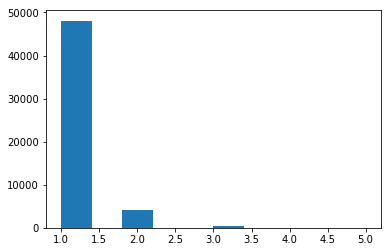

In [14]:
plt.hist(df_UsrRating.usr_rating)

In [15]:
#We could clip the play counts to be binary, e.g., any number greater than 2 is mapped to 1, otherwise it's 0.
#df_UsrRating.loc[df_UsrRating.usr_rating == 1,"usr_rating"] = 0
#df_UsrRating.loc[df_UsrRating.usr_rating > 1,"usr_rating"] = 1

Another feature to add to the model is the lyrics "popularity", derived looking at how many times a track was globally played. This quantity will be scaled by its maximum measure, in order to get a rating classification between 0 and 1 

In [16]:
df_GlobRating = (df_sessions[["user_id","song_id"]]
                 .groupby("song_id")
                 .count()
                 .reset_index()
                 .rename(columns={'user_id':'popolarity'}))

df_GlobRating["popolarity"] = df_GlobRating["popolarity"]/df_GlobRating["popolarity"].max()#head(10)

In [17]:
df_rating = df_GlobRating.merge(df_UsrRating, how = "left", on=["song_id"])

In [18]:
np.sqrt(np.var(df_rating.usr_rating))

0.32169565145983653

#### Data manipulation:  merge & filtering

- We want to aggregte all the data into a single dataframe. 

- NaNs will be generated where user sessions cannot be mapped to the track catalogues. 

- The $\textit{song_id}$ corresponding to these NAs will be filtered out in a differnt dataframe, namely $\textit{df_preds}$, that will be used at the vey end for predictions. 

- Data in $\textit{tracks_to_complete.csv}$ should be at least a subset of $\textit{df_preds}$ 

In [19]:
df_sessions = df_sessions.merge(df_rating, how = "left", on=["user_id","song_id"])

In [20]:
dfOverall = df_sessions.merge(df_tracks, how = "left", on=["song_id"])

In [21]:
print(dfOverall.shape)
dfOverall.sort_values(by=["user_id","song_id","timestamp"]).head(10)

(57424, 7)


,user_id,song_id,timestamp,popolarity,usr_rating,duration,genre
37858,0.0,17179869185,1.464394e+09,0.151163,1,97.0,blues
7512,0.0,85899345921,1.454597e+09,0.232558,1,53.0,blues
49199,0.0,111669149698,1.454596e+09,0.860465,1,54.0,blues
7174,0.0,489626271744,1.465710e+09,0.069767,1,39.0,rock
37398,0.0,523986010112,1.447600e+09,0.197674,1,107.0,blues
29237,0.0,532575944704,1.479566e+09,0.174419,2,33.0,rap
23456,0.0,532575944704,1.488145e+09,0.174419,2,33.0,rap
43757,0.0,541165879298,1.465710e+09,0.116279,1,NaN,NaN
26460,0.0,627065225218,1.490830e+09,0.023256,1,262.0,rock
36118,0.0,635655159810,1.557653e+09,0.034884,1,64.0,rock


Each user listenend to a total number of tracks equal to: 

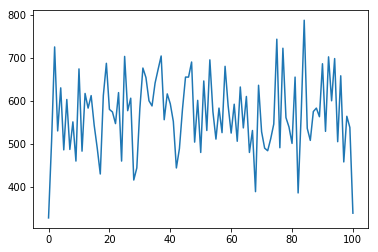

In [22]:
totNtracks = dfOverall[["user_id","song_id"]].groupby("user_id").count().reset_index().rename(columns={'song_id':'usr_totTrack'})
plt.plot(totNtracks.usr_totTrack)

In [23]:
print "minumum number of listened tracks %d" % (totNtracks.usr_totTrack.min())

minumum number of listened tracks 328


On average, each user listens to music tracks for the following average duration (in seconds)

In [24]:
avgTime = dfOverall[["user_id","duration"]].groupby("user_id").mean().reset_index().rename(columns={'duration':'usr_avgSession'})
#avgTime.head(5)

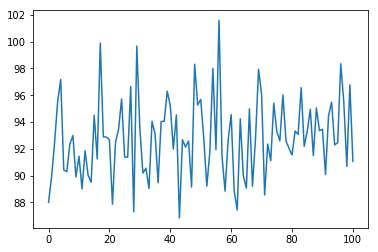

In [25]:
plt.plot(avgTime.usr_avgSession)

merging ..

In [26]:
globFeatures = avgTime.merge(totNtracks,how = "inner", on=["user_id"] )

In [27]:
dfOverall = dfOverall.merge(globFeatures, how = "left", on=["user_id"])
print(dfOverall.shape)

(57424, 9)


In [28]:
df_preds = dfOverall[dfOverall.genre.isnull()]
df = dfOverall[-dfOverall.genre.isnull()]

In [29]:
print( "Data is split in a DF for modelling with %d observations and in a DF for final predictions with %d " % (df.shape[0],df_preds.shape[0]))

Data is split in a DF for modelling with 46084 observations and in a DF for final predictions with 11340 


In [30]:
#df_preds.sort_values(["song_id","usr_rating"])

In [31]:
df.sort_values(by=["user_id","song_id"], ascending = True).head()

,user_id,song_id,timestamp,popolarity,usr_rating,duration,genre,usr_avgSession,usr_totTrack
37858,0.0,17179869185,1.464394e+09,0.151163,1,97.0,blues,88.01732,328
7512,0.0,85899345921,1.454597e+09,0.232558,1,53.0,blues,88.01732,328
49199,0.0,111669149698,1.454596e+09,0.860465,1,54.0,blues,88.01732,328
7174,0.0,489626271744,1.465710e+09,0.069767,1,39.0,rock,88.01732,328
37398,0.0,523986010112,1.447600e+09,0.197674,1,107.0,blues,88.01732,328


Let's compare the song_id that will be used for predictions with respect to the merged data

In [32]:
print "how many sample? %d " % df_tracks_to_complete.song_id.size
print "Exact intersection? %s" % str(set(df_preds.song_id).intersection(set(df_tracks_to_complete.song_id)) == set(df_tracks_to_complete.song_id))
print "how many common sample? %d" % len(set(df_preds.song_id).intersection(set(df_tracks_to_complete.song_id)))
print "was a fully matching subset? %s" % str(set(df_tracks_to_complete.song_id).issubset(set(df_preds.song_id)))

how many sample? 1265 
Exact intersection? False
how many common sample? 1209
was a fully matching subset? False


Therefore, there are some elements in $\textit{df_tracks_to_complete}$ that are not present in $\textit{df_preds}$.

These elements should be filtered out from $\textit{df_tracks_to_complete}$ since it is not possible to model anything due to the lack of any inforamtion.

In [33]:
## elememnts in df_tracks_to_complete that are not in df_preds ? 
discrepancy = (set(df_tracks_to_complete.song_id).difference(set(df_preds.song_id)))
print "In tracks_to_complete.csv there are %d observations without any session/catalogue information" % len(discrepancy)
df_tracks_to_complete_filtered = df_tracks_to_complete[~df_tracks_to_complete["song_id"].isin(list(discrepancy))]

In tracks_to_complete.csv there are 56 observations without any session/catalogue information


In [34]:
len(df.song_id.unique())

4758

Up to now, the **cleaned** dataset that will be used for modelling is composed by **101 users**, **5 genres**, **4758 lyrics** and **46084 observations** (sessions)   

## Modelling 

Different techniques should be applied. Standard classifier (e.g., neighbours search and gradient boosting) will be explored. A different solution could arise from the user pattern analysis of lyrics temporal sequences.

Aiming to achieve quick resultss, I will divide the data only in training (70%) and test (30%) sets, without performing cross validation for hyper-parameters tuning, as a first approximation to find out the best model. 

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

In [36]:
from __future__ import print_function

import logging
import numpy as np
from time import time

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.metrics import classification_report

In [37]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)
    
    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)
    

    print("classification report:")
    print(metrics.classification_report(y_test, pred))

    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

#### Data pre-processing 1

Since we are interested in predicting only the genre, I will drop the "duration" information that is missing when doing the predictions.

In [38]:
dfWhole = df.drop(labels=["duration"], axis=1).set_index("timestamp")

In [39]:
dfWhole.head()

,user_id,song_id,popolarity,usr_rating,genre,usr_avgSession,usr_totTrack
timestamp,,,,,,,
1.486218e+09,21.0,7954279432194,0.174419,1,rock,87.872463,574
1.477860e+09,12.0,10307921510401,0.186047,1,reggae,91.859174,617
1.479925e+09,90.0,12300786335744,0.081395,1,reggae,93.457371,686
1.406806e+09,56.0,14156212207616,0.441860,3,blues,101.595625,583
1.495963e+09,12.0,4853313044481,0.058140,1,rock,91.859174,617


Finally, let's create a train and test dataset by using stratified sampling, to reproduce the relative unbalanced proportions of music genre in the session datasets. Indeeds, some genre frequencies were unbalance already at the level of the track dataset:

In [40]:
df_tracks.groupby("genre").count()["song_id"]

genre
blues       807
electro     394
rap         593
reggae      785
rock       2406
Name: song_id, dtype: int64

In [41]:
X_train, X_test, y_train, y_test = train_test_split(dfWhole.drop(labels=['genre'], axis=1), dfWhole.genre, test_size = 0.3, stratify=dfWhole.genre,random_state=42)

#### Models

Several classification approaces are explored. Togheter with the accuracy metrics, a more suitable performance metrics is the f1_score, since genres classes are not balanced.

I will concentrate more on a kNN classifier. To address the inefficiencies of KD Trees in higher dimensions, the ball tree data structure will be used as algorithms methods. 

In [42]:
results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (KNeighborsClassifier(n_neighbors=20, algorithm = "ball_tree"), "kNN_20_ball"),
        #(KNeighborsClassifier(n_neighbors=10, algorithm = "ball_tree"), "kNN_10_ball"),
        (KNeighborsClassifier(n_neighbors=50, algorithm = "ball_tree"), "kNN_50_ball"),
        #(KNeighborsClassifier(n_neighbors=5, algorithm = "ball_tree"), "kNN_5_ball"),
        (KNeighborsClassifier(n_neighbors=100, algorithm = "ball_tree"), "kNN_100_ball"),
        #(KNeighborsClassifier(n_neighbors=20, metric="cosine", algorithm = "brute"), "kNN_1"),
        (KNeighborsClassifier(n_neighbors=50, metric="cosine",algorithm = "brute"), "kNN_50"),
        #(KNeighborsClassifier(n_neighbors=200, metric="cosine",algorithm = "brute"), "kNN_200"),
        (AdaBoostClassifier( n_estimators=50), "adaboost_50"),
        (AdaBoostClassifier( n_estimators=500), "adaboost_500"),
        (GradientBoostingClassifier(n_estimators=2000), "gradientboost_2000"),
        (GradientBoostingClassifier(n_estimators=3000), "gradientboost_3000"),
        #(GradientBoostingClassifier(n_estimators=900), "gradientboost_900"),
        #(GradientBoostingClassifier(n_estimators=1200), "gradientboost_1200"),
        #(GradientBoostingClassifier(n_estimators=1000), "gradientboost_1000"),
        #(GradientBoostingClassifier(n_estimators=1500), "gradientboost_1500"),
        (RandomForestClassifier(n_estimators=500), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)
train time: 0.108s
test time:  0.002s
accuracy:   0.359
classification report:
             precision    recall  f1-score   support

      blues       0.36      0.49      0.42      4797
    electro       0.00      0.00      0.00       988
        rap       0.00      0.00      0.00       922
     reggae       0.00      0.00      0.00      2290
       rock       0.36      0.54      0.43      4829

avg / total       0.25      0.36      0.29     13826

confusion matrix:
[[2368    0    0    0 2429]
 [ 428    0    0    0  560]
 [ 486    0    0    0  436]
 [1046    0    0    0 1244]
 [2238    0    0    0 2591]]

Perceptron
________________________________________________________________________________
Training: 
Perc

/Users/aagostinelli/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train time: 0.519s
test time:  0.001s
accuracy:   0.350
classification report:
             precision    recall  f1-score   support

      blues       1.00      0.00      0.00      4797
    electro       0.00      0.00      0.00       988
        rap       0.00      0.00      0.00       922
     reggae       0.00      0.00      0.00      2290
       rock       0.35      1.00      0.52      4829

avg / total       0.47      0.35      0.18     13826

confusion matrix:
[[   7    0    0    0 4790]
 [   0    0    0    0  988]
 [   0    0    0    0  922]
 [   0    0    0    0 2290]
 [   0    0    0    0 4829]]

kNN_20_ball
________________________________________________________________________________
Training: 
KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform')
train time: 0.043s
test time:  0.059s
accuracy:   0.668
classification report:
             precision    recall  

test time:  2.666s
accuracy:   0.912
classification report:
             precision    recall  f1-score   support

      blues       0.98      0.95      0.97      4797
    electro       0.92      0.85      0.88       988
        rap       0.83      0.74      0.78       922
     reggae       0.92      0.86      0.89      2290
       rock       0.86      0.95      0.90      4829

avg / total       0.91      0.91      0.91     13826

confusion matrix:
[[4571   13   12   21  180]
 [   5  838   13   19  113]
 [   9    5  680   31  197]
 [  20   18   20 1960  272]
 [  43   32   91   99 4564]]

Random forest
________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_j

In [43]:
for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty=penalty)))

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
     verbose=0)
train time: 0.128s
test time:  0.002s
accuracy:   0.349
classification report:
             precision    recall  f1-score   support

      blues       0.00      0.00      0.00      4797
    electro       0.00      0.00      0.00       988
        rap       0.00      0.00      0.00       922
     reggae       0.00      0.00      0.00      2290
       rock       0.35      1.00      0.52      4829

avg / total       0.12      0.35      0.18     13826

confusion matrix:
[[   0    0    0    0 4797]
 [   0    0    0    0  988]
 [   0    0    0    0  922]
 [   0    0    0    0 2290]
 [   0    0    0    0 4829]]

_____________________________________________________________________

In [44]:
# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

Naive Bayes
________________________________________________________________________________
Training: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
train time: 0.080s
test time:  0.002s
accuracy:   0.106
classification report:
             precision    recall  f1-score   support

      blues       0.39      0.05      0.10      4797
    electro       0.08      0.46      0.13       988
        rap       0.07      0.48      0.12       922
     reggae       0.13      0.00      0.01      2290
       rock       0.36      0.06      0.11      4829

avg / total       0.29      0.11      0.09     13826

confusion matrix:
[[ 263 2000 2230   25  279]
 [  41  454  416    3   74]
 [  54  365  440    2   61]
 [  94 1059  985    7  145]
 [ 225 2164 2117   15  308]]

________________________________________________________________________________
Training: 
BernoulliNB(alpha=0.01, binarize=0.0, class_prior=None, fit_prior=True)
train time: 0.082s
test time:  0.003s
accuracy:   0.350
cla

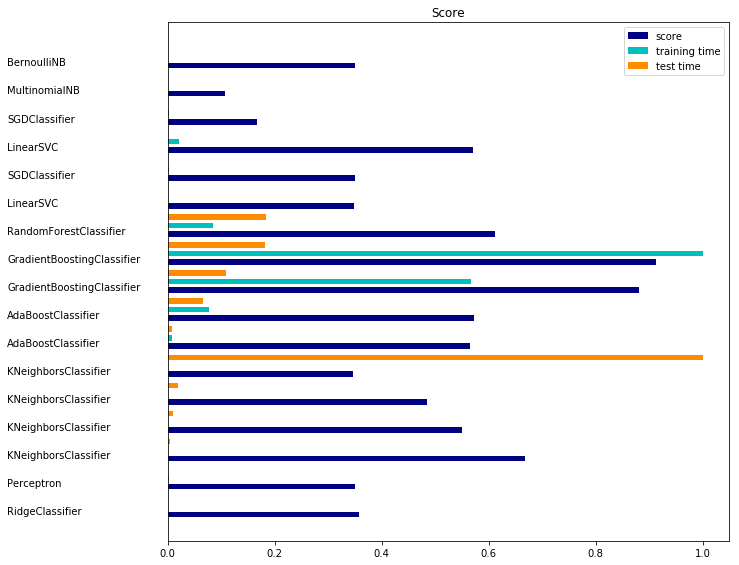

In [45]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

### Best Hyperparameters Grdid Search with Cross Validation

To achieve better results with respect to those already obtained, a fine-tuning of the hyper-parameters by mean of a gridSearch cross validation shoudl be expected. It is highly computational requirinq, though.

## Running the best model on the unobserved dataset

The **best preformance** has been achieved by using a **GradientBoostingClassifier** with **3000 estimators** (decision trees). This model has performed with an **accuracy of 91.2%** and an average **f1_score of 91% ** on the test set.

The structure of the training and test sets is recreated: 

In [42]:
df_preds = df_preds.drop(labels=["duration","genre"], axis=1).set_index("timestamp")

In [43]:
bestModel = GradientBoostingClassifier(n_estimators=3000)

In [44]:
bestModel.fit(dfWhole.drop(labels="genre", axis=1), dfWhole.genre)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=3000, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [45]:
import pickle
pickle.dump( bestModel, open( "BestModel.p", "wb" ) )

Finally, prediction of the music genre are generetaed and printed out on a csv file, after having filtered for uninformative tracks with any information in the session files. 

In [46]:
pred = bestModel.predict(df_preds)

In [47]:
df_preds["predicted_genre"] = pred

In [48]:
df_preds = df_preds.reset_index()

In [49]:
#df_preds[["user_id","song_id","timestamp"]].sort_values(["user_id","song_id","timestamp"])

In [144]:
df_preds[["song_id","predicted_genre"]].to_csv("tmp_overall_predictions.csv",index =False)

In [51]:
filteredLis = (list(set(df_preds.song_id).intersection(set(df_tracks_to_complete.song_id))))

For a given song_id there might be multiple answers due to: 

- same genre predictions from different user_id
- different genre predictions from different user_id

In the first case, a filtering across replicates will be usesd, whereas for the second case for simplicity the first answer among the possible outcomes will be picked up.   

In [70]:
df_predsFiltered = df_preds[["song_id","predicted_genre"]].sort_values(["song_id","predicted_genre"]).drop_duplicates(keep="first")

In [140]:
df_Final = df_predsFiltered.drop_duplicates(subset="song_id", keep="first")
print(df_Final.shape)

(1209, 2)


This was a quick and dirty work-around. In order to map the outcome best estimation with the genre measured distribution, the best choice would be done by extracting a random number $f_r$ from a uniform distribution in [0,1] and comparing its value with the per class frequecnies, given by:


In [136]:
df_predsFiltered[df_predsFiltered.song_id.isin(filteredLis)].shape

(1451, 2)

In [142]:
df.groupby("genre").count()["song_id"]/df.shape[0]

genre
blues      0.346932
electro    0.071500
rap        0.066661
reggae     0.165611
rock       0.349297
Name: song_id, dtype: float64

So that:
  - if $fgenre_j < fr < fgenre_i$  --> Genre "i" is chosen 
  - if $f_r < fgenre_k< fgenre_i < fgenre_j$ --> Genre "k" is chosen 
  - ad so on ..
  

We can finally save the list of predictions in the format requested by the test

In [143]:
df_predsFiltered.to_csv("solutions.csv",index =False)

# Appendix 

By using only the information given by song_id, user_id and the number of times a lyrics was played (proxy of the rating), it is possible to perform a pivot of the previous dataframes in order to create a Df with lyrics labels associated to a given combination of user. This methodology is closer to what is usually done in collaborative filtering but it is not as performing as the previous approach

#### Data pre-processing 2

In [64]:
df_filtered = df.drop(labels=["timestamp"], axis=1).drop_duplicates(keep="first")

Pivoting

In [65]:
df_pivot = df_filtered.pivot(index = 'song_id', columns ='user_id', values = 'usr_rating').fillna(0).reset_index()

In [66]:
reshaped_df = (df_pivot
               .merge(df_filtered.drop(labels=["user_id","usr_rating","usr_avgSession","duration","usr_totTrack","popolarity"], axis=1), how = "inner", on=["song_id"])
               .drop_duplicates(keep = "first"))

It is possible now to create a train and test dataset by using stratified sampling, to respect the relative proportions of music genres in the session datasets. Indees, some genre frequencies were unbalance already at the level of the track dataset

In [67]:
df_tracks.groupby("genre").count()["song_id"]

genre
blues       807
electro     394
rap         593
reggae      785
rock       2406
Name: song_id, dtype: int64

In [68]:
X_train, X_test, y_train, y_test = train_test_split(reshaped_df.drop(labels=['genre'], axis=1), reshaped_df.genre, test_size = 0.3, stratify=reshaped_df.genre,random_state=42)

In [69]:
X_train.head()

,song_id,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,...,91.0,92.0,93.0,94.0,95.0,96.0,97.0,98.0,99.0,100.0
6858,2869038153730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33258,13589276524546,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33158,13554916786176,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34350,14035953123330,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26180,10642928959488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


kf = KFold(n_splits=5)
for train, test in kf.split(X):
    print("%s %s" % (train, test))
    

In [70]:
results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (KNeighborsClassifier(n_neighbors=20, algorithm = "ball_tree"), "kNN_20_ball"),
        (KNeighborsClassifier(n_neighbors=1, metric="cosine", algorithm = "brute"), "kNN_1"),
        (KNeighborsClassifier(n_neighbors=4, metric="cosine",algorithm = "brute"), "kNN_4"),
        (KNeighborsClassifier(n_neighbors=10, metric="cosine",algorithm = "brute"), "kNN_10"),
        (KNeighborsClassifier(n_neighbors=50, metric="cosine",algorithm = "brute"), "kNN_50"),
        (KNeighborsClassifier(n_neighbors=200, metric="cosine",algorithm = "brute"), "kNN_200"),
        (AdaBoostClassifier( n_estimators=50), "adaboost_50"),
        (AdaBoostClassifier( n_estimators=500), "adaboost_500"),
        (GradientBoostingClassifier(n_estimators=50), "gradientboost_50"),
        (GradientBoostingClassifier(n_estimators=500), "gradientboost_500"),
        (RandomForestClassifier(n_estimators=500), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)
train time: 0.025s
test time:  0.003s
accuracy:   0.480
classification report:
             precision    recall  f1-score   support

      blues       0.00      0.00      0.00       239
    electro       0.00      0.00      0.00       113
        rap       0.00      0.00      0.00       162
     reggae       0.00      0.00      0.00       228
       rock       0.48      1.00      0.65       686

avg / total       0.23      0.48      0.31      1428

confusion matrix:
[[  0   0   0   0 239]
 [  0   0   0   0 113]
 [  0   0   0   0 162]
 [  0   0   0   0 228]
 [  0   0   0   0 686]]

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, clas

train time: 4.580s
test time:  0.203s
accuracy:   0.444
classification report:
             precision    recall  f1-score   support

      blues       0.41      0.52      0.46       239
    electro       0.26      0.33      0.29       113
        rap       0.26      0.36      0.30       162
     reggae       0.39      0.23      0.29       228
       rock       0.59      0.53      0.56       686

avg / total       0.46      0.44      0.45      1428

confusion matrix:
[[125  12  16  17  69]
 [  9  37  10   8  49]
 [ 17  14  58   9  64]
 [ 52  12  40  53  71]
 [105  69 101  50 361]]

gradientboost_50
________________________________________________________________________________
Training: 
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.

In [71]:
for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty=penalty)))

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
     verbose=0)
train time: 0.022s
test time:  0.002s
accuracy:   0.480
classification report:
             precision    recall  f1-score   support

      blues       0.00      0.00      0.00       239
    electro       0.00      0.00      0.00       113
        rap       0.00      0.00      0.00       162
     reggae       0.00      0.00      0.00       228
       rock       0.48      1.00      0.65       686

avg / total       0.23      0.48      0.31      1428

confusion matrix:
[[  0   0   0   0 239]
 [  0   0   0   0 113]
 [  0   0   0   0 162]
 [  0   0   0   0 228]
 [  0   0   0   0 686]]

________________________________________________________________________________
Training: 
SG

In [72]:
# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

Naive Bayes
________________________________________________________________________________
Training: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
train time: 0.013s
test time:  0.001s
accuracy:   0.480
classification report:
             precision    recall  f1-score   support

      blues       0.35      0.60      0.44       239
    electro       0.51      0.18      0.26       113
        rap       0.24      0.20      0.22       162
     reggae       0.42      0.19      0.26       228
       rock       0.61      0.65      0.63       686

avg / total       0.48      0.48      0.46      1428

confusion matrix:
[[143   2  12  18  64]
 [ 35  20   7   2  49]
 [ 31   3  33   7  88]
 [ 69   2  27  43  87]
 [136  12  59  33 446]]

________________________________________________________________________________
Training: 
BernoulliNB(alpha=0.01, binarize=0.0, class_prior=None, fit_prior=True)
train time: 0.014s
test time:  0.004s
accuracy:   0.548
classification report:
     

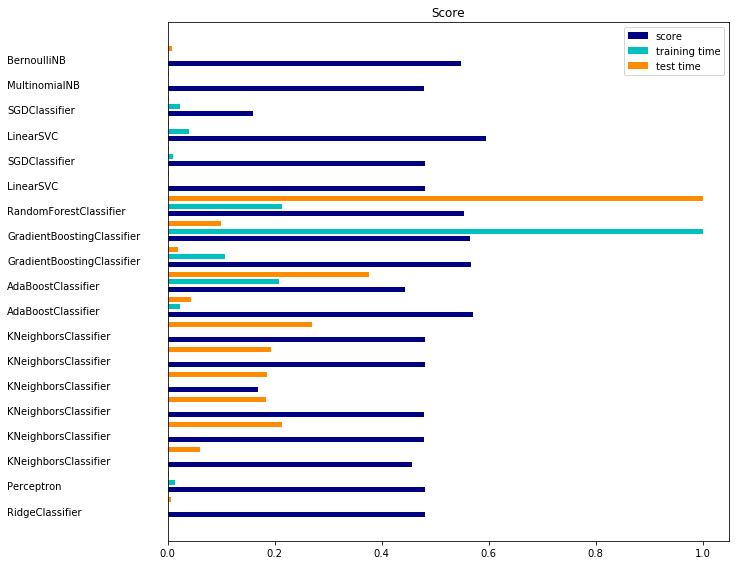

In [73]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()